# Deep Learning Project - Batch 22
## Title: Detection and Prediction Air Pollution Level in a Specific City Using Deep Learning
### NAME                                              ID
### SAI CHARAN LANKA        -       2000032220
### JALDU DURGA SRAVYA   -     2000032222
### RAVURI TANUJA SAI        -       2000032224

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display
warnings.filterwarnings("ignore")



Enter the City Name:
Delhi
Shape of train data:(48, 1)
Shape of test data:(13, 1)
Given the Array: 
[0.67487834 0.63964965 0.46337057 0.58406109 0.6903082  0.46893587
 0.32655914 0.37015839 0.38790668 0.63246601 0.82878394 0.70684585]
Predict this y: 
 [[0.91922402]]


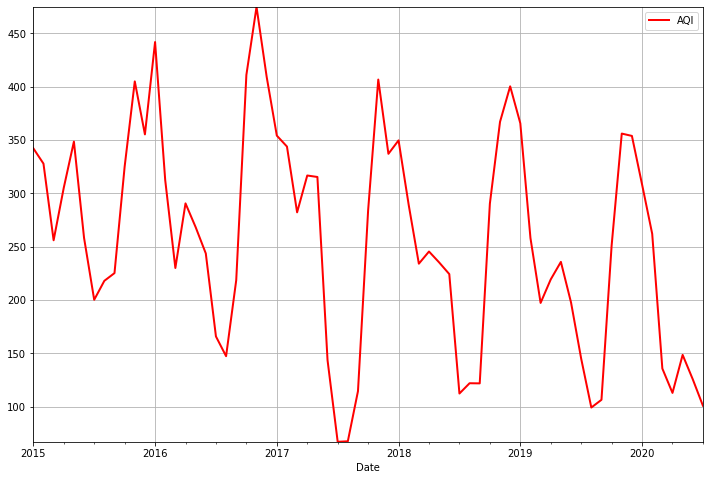

In [2]:
#Read the Dataset
df= pd.read_csv("city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

#Pre-Processing and Feature Extraction
df=df[['City','Date','AQI']]

#Input the Specified City Name
print("Enter the City Name:")
city=input()

data = df[df['City'] == city]
data.drop(['City'],axis=1,inplace = True)
data.set_index('Date', inplace = True)

data['AQI'].fillna(method = 'bfill',inplace = True)

data=data.astype('float64')
data=data.resample(rule='MS').mean()

#Plotting the AQI values in the specific city
ax=data[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

#Splitting the Training and Testing Data
train=data[:48]
test=data[48:61]

print("Shape of train data:" + str(train.shape))
print("Shape of test data:" + str(test.shape))

train_arr = train
test_arr = test

scaler = MinMaxScaler()
scaler.fit(train_arr)

scaled_train = scaler.transform(train_arr)
scaled_test = scaler.transform(test_arr)

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

# RNN-LSTM Model Creation
model = Sequential(name = 'LSTM-Model')
model.add(LSTM(32, activation='relu', return_sequences = True, input_shape=(n_input, n_features),name = "LSTM_1"))
model.add(LSTM(32, activation='relu',name = "LSTM_2"))
model.add(Dense(1,name = "DENSE_1"))
model.compile(optimizer= 'adam',  loss='mse')



In [3]:
model.summary()
#Plotting Architecture of the Model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir="TB",dpi=96)

#Compiling the model
model.fit_generator(generator,epochs=100)



Model: "LSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 12, 32)            4352      
                                                                 
 LSTM_2 (LSTM)               (None, 32)                8320      
                                                                 
 DENSE_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
36/36 [==============================] - 3s 8ms/step - loss: 0.1518
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0813
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0767
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.

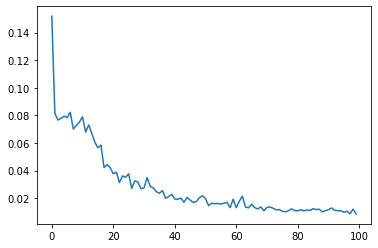

In [4]:
#Plotting the graph for loss-per-epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)



In [5]:
#Predctions on the testing-data in batches
test_predictions = []

first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

test_predictions = scaler.inverse_transform(test_predictions)

test_arr['Predictions'] = test_predictions



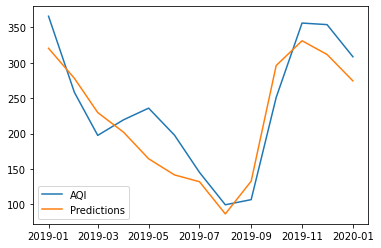

In [6]:
#Plotting the Graph for AQI vs Predictions
plt.plot(test_arr['AQI'],label = 'AQI')
plt.plot(test_arr['Predictions'],label = 'Predictions')
plt.legend()


In [7]:

#RMSE for the Model
RMSE_test=np.sqrt(mean_squared_error(test_arr['AQI'],test_arr['Predictions']))
print('RMSE on the testing dataset = ',RMSE_test)
print('India_AQI=',test_arr['AQI'].mean())


RMSE on the testing dataset =  37.92914783818242
India_AQI= 238.05046082949306
